# Quantum Gaussian Filter

## Overview

A Gaussian filter is a function localized around a parameter $\mu$. Interpreting this parameter as the desired energy level, the quantum Gaussian filter is an operator of the system Hamiltonian which acts as the projection onto an energy subspace near $\mu$. Given a Hamiltonian $H$, the quantum Gaussian filter is
\begin{equation}
\text{exp}(-(H-\mu I)^2/\sigma^2).
\end{equation}
Here, $\sigma^2$ controls the width of the Gaussian. This filter is a useful subroutine in preparing ground states and solving linear system problems.

## Polynomial approximation

Suppose the Hamiltonian is normalized and shifted so that $0 \prec H \prec I$. The interval of interest becomes $x \in (0,1)$. Hence, we only need to approximate the following function accurately in the positive half interval to implement the quantum Gaussian filter $f(x) \propto \text{exp}(-(x-\mu)^2/\sigma^2)$. Extending this function as an even function, the target of the approximation is
$$ f(x) \propto \text{exp}(-(|x|-\mu)^2/\sigma^2). $$
Because the eigenvalue of the Hamiltonian is in $x \in (0,1)$, it suffices to implement the quantum Gaussian filter $f(H) \propto \text{exp}(-(H-\mu I)^2 / \sigma^2)$.

For the following numerical demonstration, we will consider an even function $f(x) = 0.99 * \text{exp}(-(|x|-0.5)^2/0.1^2)$ whose $L^\infty$ norm over $[-1,1]$ is strictly bounded by $0.99 \approx 1$, which is very close to the fully-coherent regime $||f||_\infty \approx 1$.

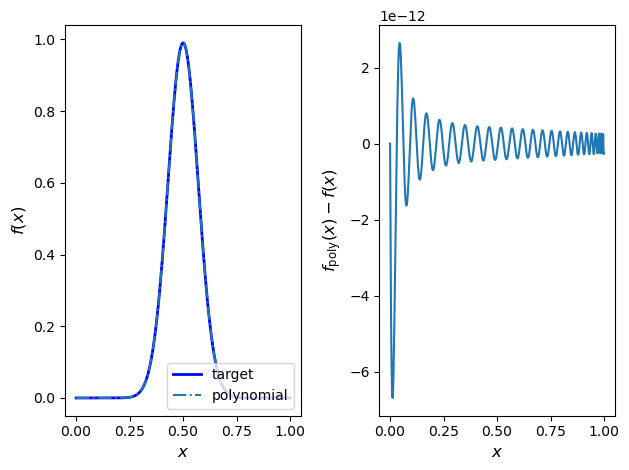

In [1]:
import numpy as np
from numpy.polynomial.chebyshev import chebinterpolate, chebval
import matplotlib.pyplot as plt

# Get Chebyshev coefficients
targ = lambda x: 0.99 * np.exp(-(np.abs(x) - 0.5)**2 / 0.1**2)
d = 100
parity = d % 2
coef = chebinterpolate(targ, d)

# Visualize polynomial approximation error
xlist = np.linspace(0,1,500)
targ_vals = targ(xlist)
func_vals = chebval(xlist, coef)
_, ax = plt.subplots(1,2)
targ_value = targ(xlist)

# First subplot
ax[0].plot(xlist, targ_vals, 'b-', linewidth=2, label='target')
ax[0].plot(xlist, func_vals, '-.', label='polynomial')
ax[0].set_xlabel('$x$', fontsize=12)
ax[0].set_ylabel('$f(x)$', fontsize=12)
ax[0].legend(loc='lower right')

# Second subplot
ax[1].plot(xlist, func_vals - targ_vals)
ax[1].set_xlabel('$x$', fontsize=12)
ax[1].set_ylabel('$f_\\mathrm{poly}(x)-f(x)$', fontsize=12)
plt.tight_layout()
plt.show()

# Only need Chebyshev coefficients with specified parity
coef = coef[parity::2]

## Solve for phase factors and verify

iter err          
   1  +2.0557e-01
   2  +4.6388e-02
   3  +8.9034e-03
   4  +8.8606e-04
   5  +1.3739e-05
   6  +3.5193e-09
Stop criteria satisfied.
The residual error is
8.548717289613705e-15


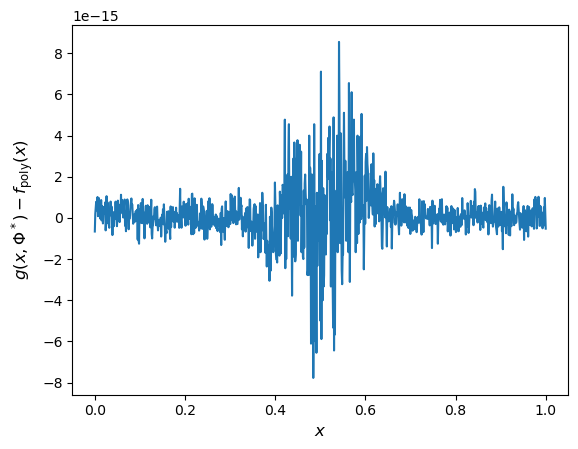

In [2]:
# Set up parameters
opts = {
    'maxiter': 100,
    'criteria': 1e-12,
    'targetPre': True,
    'useReal': True,
    'method': 'Newton'
}

# Run solver for phase factors
from qsppack.solver import solve
phi_proc, out = solve(coef, parity, opts)

# Necessary imports for verification
import matplotlib.pyplot as plt
from qsppack.utils import chebyshev_to_func, get_entry

# Compute residual error
xlist = np.linspace(0, 1, 1000)
func = lambda x: chebyshev_to_func(x, coef, parity, True)
targ_value = targ(xlist)
func_value = func(xlist)
QSP_value = get_entry(xlist, phi_proc, out)
err = np.linalg.norm(QSP_value - func_value, np.inf)
print('The residual error is')
print(err)

# Plot result
plt.plot(xlist, QSP_value - func_value)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$g(x,\\Phi^*)-f_\\mathrm{poly}(x)$', fontsize=12)
plt.show()

## Reference
1. Lin, L., & Tong, Y. (2020). Optimal polynomial based quantum eigenstate filtering with application to solving quantum linear systems. *Quantum*, 4, 361.

2. Lin, L., & Tong, Y. (2020). Near-optimal ground state preparation. *Quantum*, 4, 372.

3. Dong, Y., Meng, X., Whaley, K. B., & Lin, L. (2021). Efficient phase-factor evaluation in quantum signal processing. *Physical Review A*, 103(4), 042419.